# Calculating the gain for Leaky ReLU

> Explains how the gain for Kaiming initialization, $\sqrt{ \frac{2}{(1+a^2)}}$,  is calculated when the non-linear activation function is using Leaky ReLU. It is also a long-form answer to a fastai forum question "Why does kaiming use $a^2$ instead of abs(a) in the formula".

- toc: true
- badges: true
- comments: true
- category: Notes

In [3]:
#hide
import torch
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# Why does kaiming use a\*\*2 instead of abs(a) in the formula

Let's provide a long-form answer to the question below posted on fastai forum.   
  
Why is the *gain* used in Kaiming initialization expressed as $\sqrt{ \frac{2}{(1+ a^2)}}$, and not $\sqrt{ \frac{2}{(1+\left\lvert a\right\rvert)}}$, as posed in [this question](https://forums.fast.ai/t/why-does-kaiming-use-a-2-instead-of-abs-a-in-the-formula/57066) on Fastai Forum?   
Isn't the simpler $\left\lvert a \right\rvert$ a better choice compared with $a^2$?

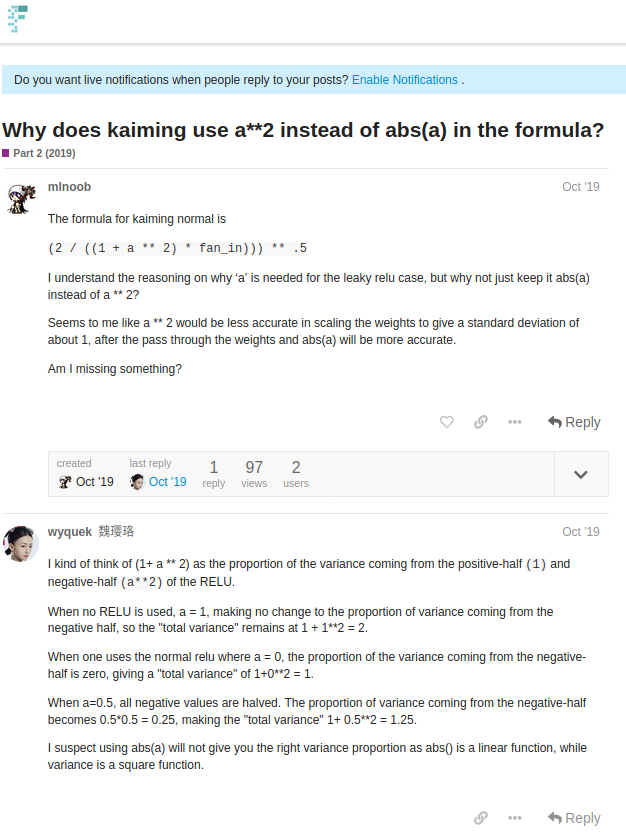

In [3]:
#hide

Image("forum_question.png")

In [ ]:
![](images/forum_question.png)

# Vanishing and exploding activations

Here's a simple function that would inform us, when we run 100 iterations, whether the activations explode, vanish or behave normally.

In [21]:
def Activations(scaling_factor, iter):
    x = torch.randn(512)
    a = torch.randn(512,512)*scaling_factor
    for i in range(iter): 
        x = a @ x
        if x.std() != x.std(): 
            print("Activations exploded at iteration", i)
            return 
        if x.std() == 0: 
            print("Activations vanished at iteration", i)
            return  
    print("Activations did not explode or vanished")  
    
# adapted from https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb    

When we do nothing by setting the value of 1.0 as the scaling factor, the activations exploded at iteration 28. 

In [9]:
Activations(scaling_factor = 1, iter = 100)

Activations exploded at iteration 28


When we set the scaling factor too small at 0.01, the activations vanished at iteration 69. 

In [10]:
Activations(scaling_factor = 0.01,iter = 100)

Activations vanished at iteration 69


With the right scaling factor at $\frac{1}{\sqrt{512}}$, the activations behaved normally, completing the entire 100 iterations.

In [11]:
Activations(scaling_factor = 1/math.sqrt(512),iter = 100)

Activations did not explode or vanished


In fact, it could complete 1000 iterations without exploding or vanishing.

In [12]:
Activations(scaling_factor = 1/math.sqrt(512), iter = 1000)

Activations did not explode or vanished


> Note: For a more in-depth read, refer to Sylvain Gugger's [Why you need a good init](https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb)

# Correct scaling for init

So how do you get the correct scaling of $\frac{1}{\sqrt{512}}$ for the case described in the last section?

Let’s consider a linear neuron:

$y = (w_{1} \times x_{1}) + (w_{2} \times x_{2}) + (w_{3} \times x_{3})... + (w_{N} \times x_{N})$ 

The variance of y or  $\sigma^2(y)$ is 

 
$\sigma^2(y) = \sigma^2 [(w_{1} \times x_{1}) + (w_{2} \times x_{2}) + (w_{3} \times x_{3})... + (w_{N} \times x_{N})] $ 

Since variables $(w_{1} \times x_{1})$,$(w_{2} \times x_{2})$,..$(w_{N} \times x_{N})$ are uncorrelated, then the variance of the sum is the sum of the variances:

 
$\sigma^2(y) = \sigma^2(w_{1} \times x_{1}) + \sigma^2(w_{2} \times x_{2}) + \sigma^2(w_{3} \times x_{3})... + \sigma^2(w_{N} \times x_{N}) $ 

 
$\sigma^2(y) = \sum_{i=1}^{N} \sigma^2(w_{i} \times x_{i}) $ 
  
  

  

As all $w_{i}$ and $x_{i}$ are identically and independently distributed, we can rewrite as
 
$\sigma^2(y) = N \times \sigma^2(w \times x) $  

Note that $\sigma^2(w \times x) = E(w^2)\sigma^2(x) + E(x^2)\sigma^2(w) + \sigma^2(x)\sigma^2(w) $  

Since $w_{i}$ and $x_{i}$ are normally distributed with mean 0, $E(w_{i})= E(w_{i}^2) = E(x_{i})= E(x_{i}^2) = 0$. 

Hence we can write $\sigma^2(w \times x) = \sigma^2(w)\sigma^2(x) $   

This gives us $\sigma^2(y) = N \times \sigma^2(w) \times \sigma^2(x) $  

To keep the variance from neither exploding or vanishing, we need to keep  
 

$N \times \sigma^2(w) = 1$ so that $\sigma^2(y) =  \sigma^2(x) $

Hence we have to implement the scaling such that the variance $\sigma^2(w) = \frac{1}{N}$  

and correspondingly the standard deviation is $\sigma(w) = \frac{1}{\sqrt{N}}$  

> Note: For a more in-depth read, refer to Prateek Joshi's Blog [Understanding Xavier Initialization In Deep Neural Networks](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/
). 

# ReLU

So far we have not used any non-linear activation function yet. Here is the simple ReLU function, commonly used as the non-linear activation function in deep-learning models.

In [7]:
def ReLU(X):
   return np.maximum(0,X)

The ReLU function can be "Leaky". The plots below show how different Leaky ReLU functions affect the distribution of the outputs. The inputs come from a normal distribution of $N(0,1)$. 
When **a**, the negative slope, is 0, the negative half of the output disribution is gone. This is also the normal ReLU function.  
 
As a increases, the negative portion of the output distribution also starts to become bigger.   
  
When a is 1, the input distribution is exactly the same as the output distribution. 

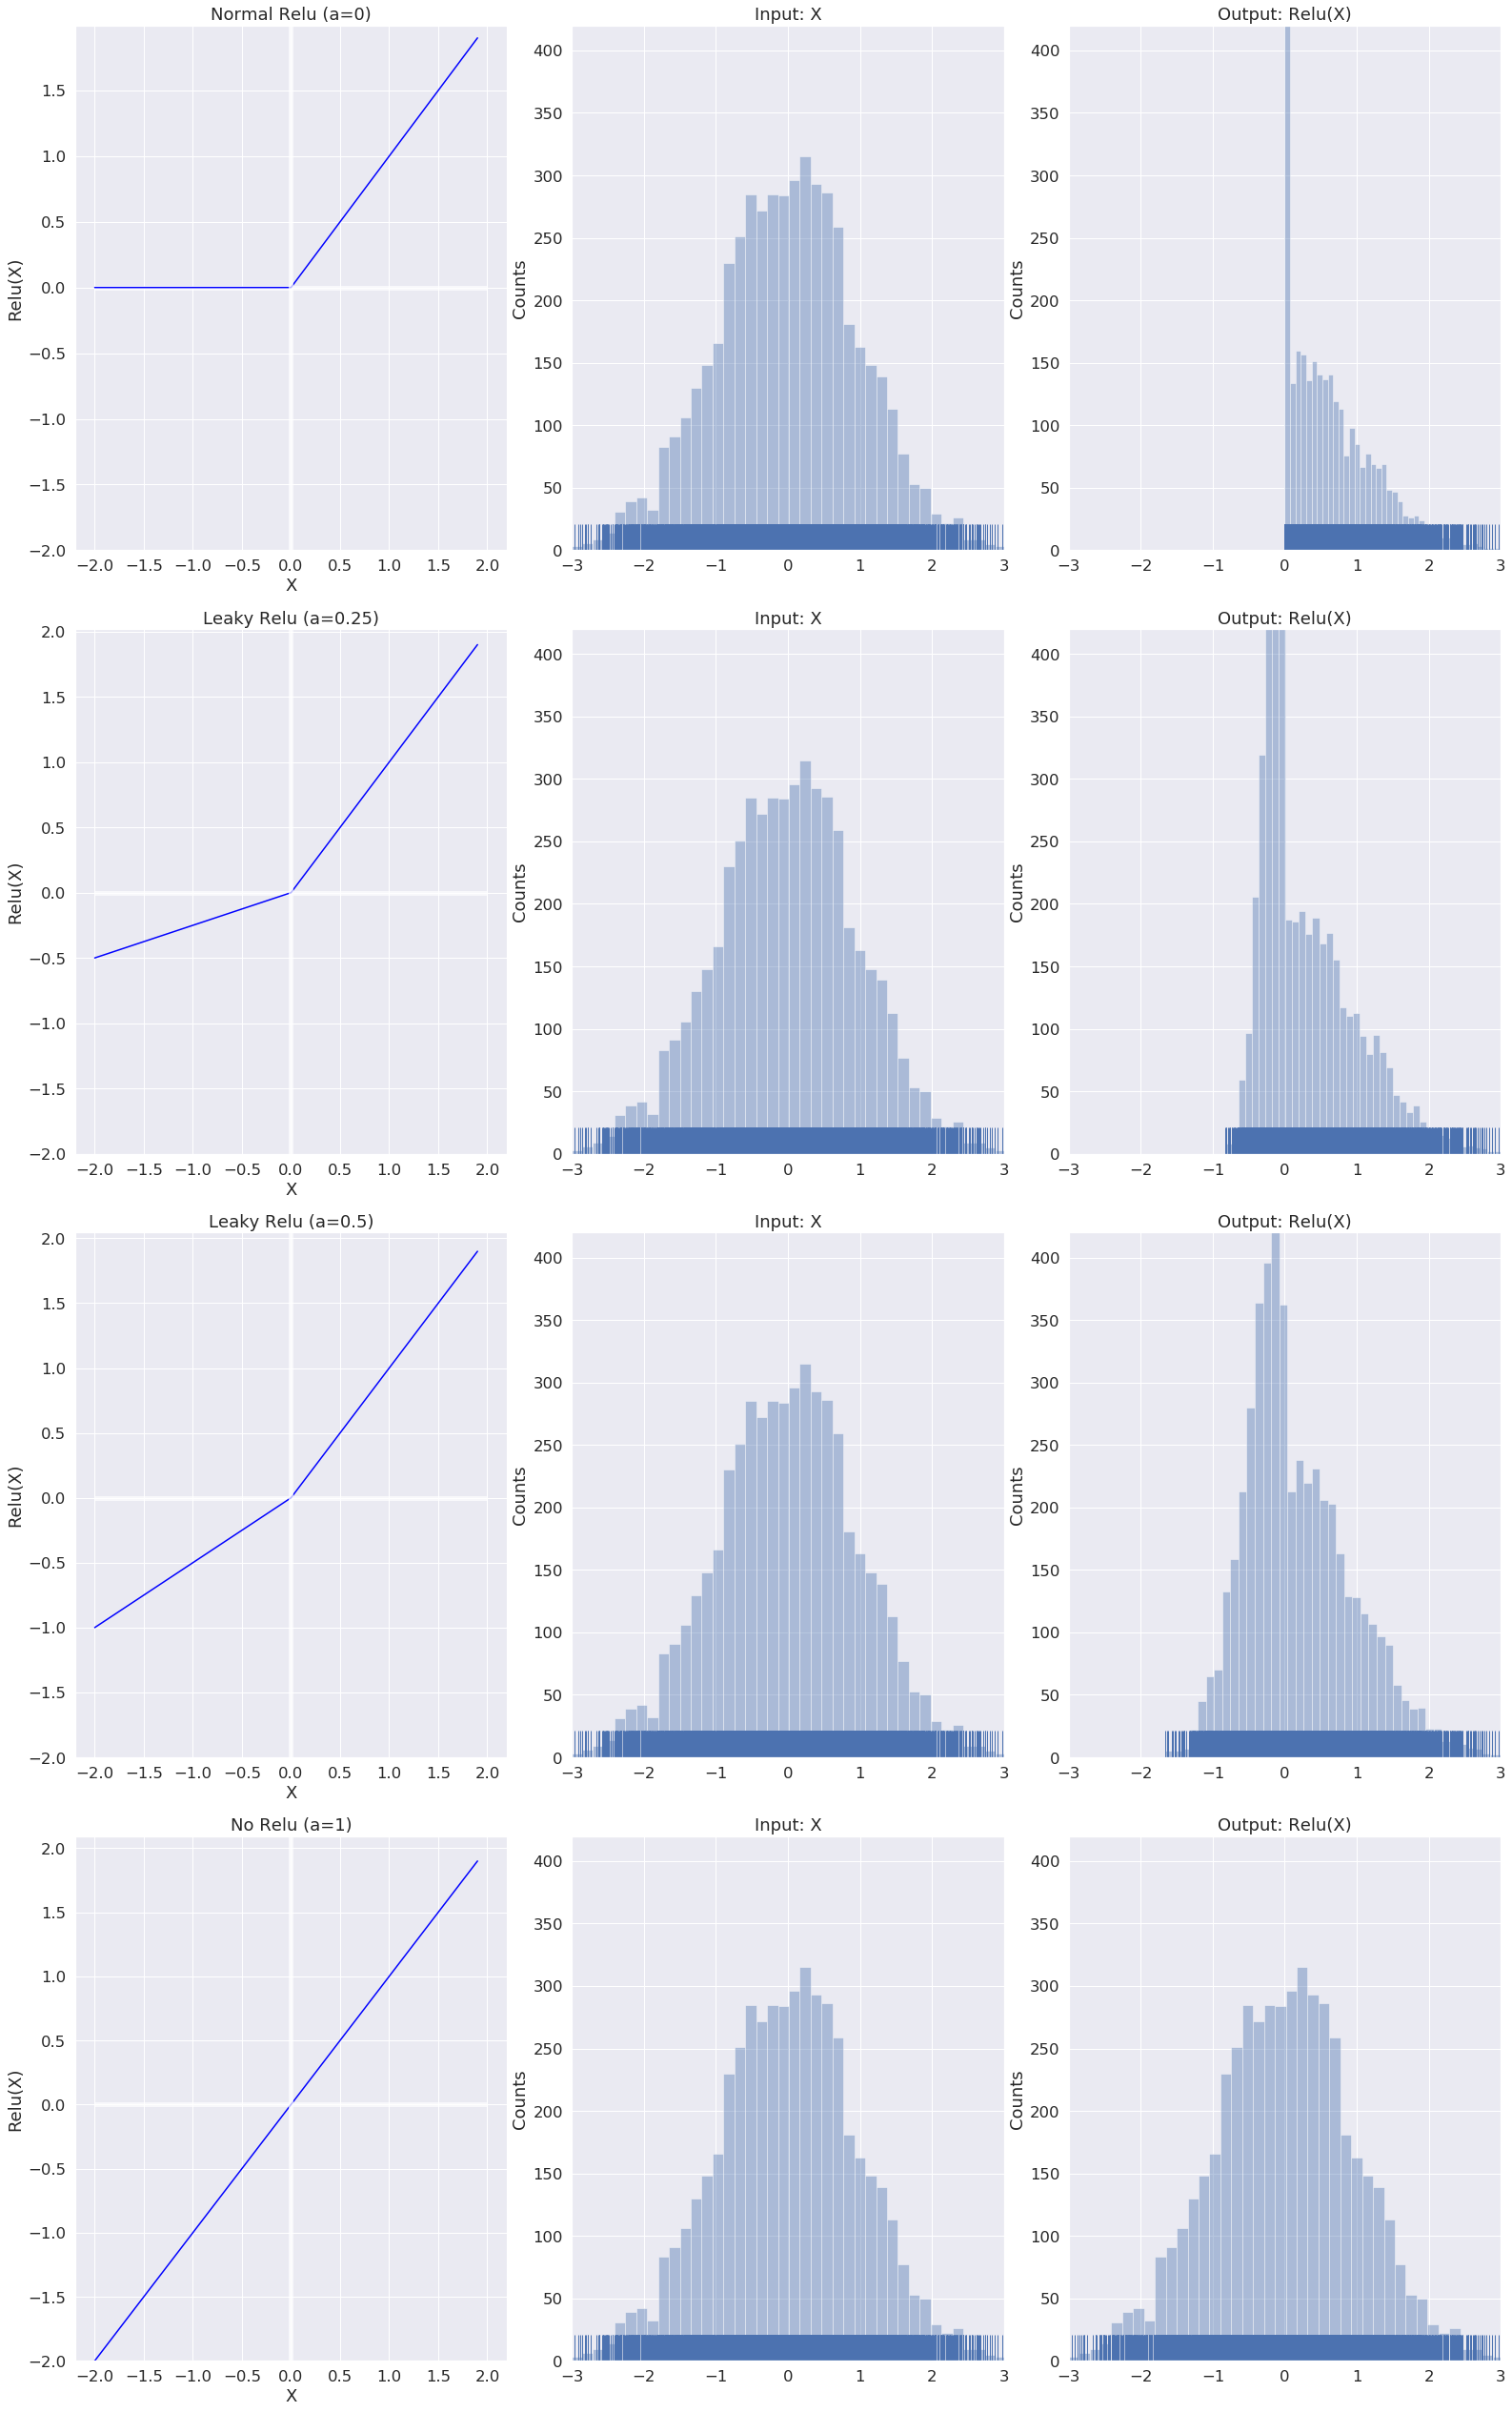

In [5]:
#collapse_hide

def leakly_relu(x, negative_slope):
    return negative_slope*x if x < 0 else x

def create_data(xs, negative_slope):
    y = [leakly_relu(x,negative_slope) for x in xs]
    return y

rows = 4
cols = 3
fig, ax = plt.subplots(rows,cols,figsize=(22,35))
fig.tight_layout()
plt.subplots_adjust(hspace = 0.15)
sns.set(font_scale= 1.5,style="darkgrid")

neg_slopes = [0, 0.25, 0.5, 1]
relu_names = ["Normal Relu", "Leaky Relu", "Leaky Relu", "No Relu"]
x1 = np.arange(-2.00, 2.00, 0.1)
x2 = np.random.normal(0, 1, 5000)

for row in range(rows):    
    sns.lineplot(x=x1, y=create_data(x1,neg_slopes[row]) ,color='blue',ax = ax[row,0])
    ax[row,0].set(xlabel='X', ylabel='Relu(X)')
    ax[row,0].set_title(f'{relu_names[row]} (a={neg_slopes[row]})')
    ax[row,0].axvline(0, -2.00,2.00,color='white', linewidth=5, alpha=.7)
    ax[row,0].hlines( y = 0, color='white', linewidth=5, alpha= 0.7, xmin = -2.00, xmax = 2.00) 
    ax[row,0].set_ylim(bottom=-2.00)

    sns.distplot(x2, color="b",ax = ax[row,1],rug=True, kde= False)
    ax[row,1].set_ylim(0,420)
    ax[row,1].set_xlim(-3,3)
    ax[row,1].set(xlabel='', ylabel='Counts')
    ax[row,1].set_title('Input: X')            

    sns.distplot(create_data(x2,neg_slopes[row]), kde=False, color="b",ax = ax[row,2],rug=True)
    ax[row,2].set_ylim(0,420)
    ax[row,2].set_xlim(-3,3)
    ax[row,2].set(xlabel='', ylabel='Counts')
    ax[row,2].set_title('Output: Relu(X)')

Clearly, looking at the plots above, we can see that after going through the different Leaky ReLU functions, the output distributions change in different manners.

The problem with having a different output distribution from the input distribution is that deep-learning models require the initialization to be precise. Otherwise, the activations would either explode or vanish.

# Correct init scaling for Leaky ReLU

Before going inot the maths, some intuition: regardless of the value of negative slope, half of the distribution remains positive and the other half negative.   
The negative half, however, might be squished together as the variance of the negtive half becomes smaller. As such, we need to calculate how much gain we need to compensate this smaller variance.    

$ Let F(y)$ = $Leaky\_ReLU(y)$

$F(y) =
  \begin{cases}
    y       & \quad \text{if } y \geq 0\\
    a \times y  & \quad \text{if } y < \text{0 where a = negative slope of Leaky ReLU}\end{cases} 
$

Note that $P(y\geq 0) =  	\frac{1}{2}$ and $P(y< 0) =  	\frac{1}{2}$ (*see Appendix for details*)

$\sigma^2(F(y)) =
  \begin{cases}
    \sigma^2(y)       & \quad \text{where } P(y \geq 0) = \frac{1}{2} \\
    \sigma^2(a \times y)  & \quad \text{where } P(y < 0) = \frac{1}{2}\end{cases} 
$

Since $\sigma^2(ax) = a^2 \times \sigma^2(x)$,

$\sigma^2(F(y)) =
  \begin{cases}
    \sigma^2(y)       & \quad \text{where } P(y \geq 0) = \frac{1}{2} \\
    a^2\sigma^2( y)  & \quad \text{where } P(y < 0) = \frac{1}{2}\end{cases} 
$

$\sigma^2(F(y)) = \frac{1}{2}\sigma^2(y) + \frac{1}{2}a^2\sigma^2( y) $

$\sigma^2(F(y)) = \frac{1}{2}\sigma^2(y)( 1 + a^2) $

$\sigma^2(F(y)) = \frac{( 1 + a^2)}{2}\sigma^2(y) $

*Since* 
$\sigma^2(y) = N \times \sigma^2(w) \times \sigma^2(x) $   

$\sigma^2(F(y)) = \frac{( 1 + a^2)}{2}\sigma^2(y) = \frac{( 1 + a^2)}{2} N \times \sigma^2(w) \times \sigma^2(x)$    

To keep the variance from neither exploding or vanishing, we need to keep $ \frac{( 1 + a^2)}{2} \times N \times \sigma^2(w) = 1$ so that $\sigma^2(y) =  \sigma^2(x) $.   

This means that the variance is  $\sigma^2(w) = \frac{1}{N} \frac{2}{( 1 + a^2)}$ and 
 
the standard deviation is $\sigma(w) = \sqrt\frac{1}{ N}\sqrt{\frac{2}{( 1 + a^2)}}$  

We can see from the above that the leaky ReLU gain is indeed $\sqrt{\frac{2}{( 1 + a^2)}}$ 

> Note: For more in-depth read into the maths of initialization, refer to Pierre Ouannes's blog
[How to initialize deep neural networks? Xavier and Kaiming initialization](https://pouannes.github.io/blog/initialization/)

# Gain in Pytorch documentation

However, so far we have not introduce the non-linear function, Leaky ReLU, into the equation. Since Leaky ReLU affects the output distribtuion, as we have seen from the plots above, the scaling should be different too. Otherwise we would encounter exploding or vanishing activations once more.  
 
When we refer to [Pytorch documentation](https://pytorch.org/docs/1.1.0/_modules/torch/nn/init.html#kaiming_normal_), we see the following: 

Fills the input Tensor with values according to the method described in *Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)*, using a normal distribution. Also known as He initialization. The resulting tensor will have values sampled from $N(0,std)$ where

In [ ]:
torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu') 

In [2]:
def kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu'):
    fan = _calculate_correct_fan(tensor, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / math.sqrt(fan)
    with torch.no_grad():
        return tensor.normal_(0, std)

There is an extra **Gain**, $\sqrt{ 	\frac{2}{(1+a^2)\times fan\_in}}$, that needs to be added to the scaling.

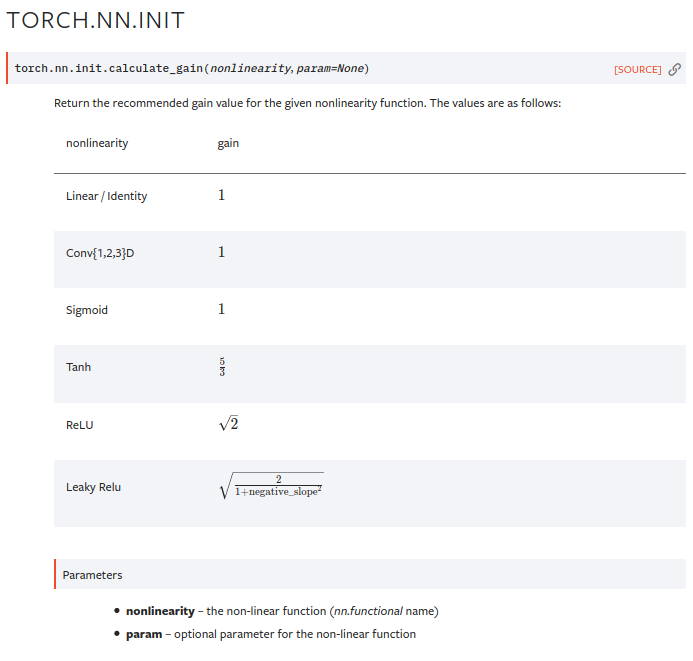

In [2]:
#hide
Image("recommended_gain_pytorch.png")

In [ ]:
![](images/recommended_gain_pytorch.png)

The *gain* for *Leaky Relu* is $\sqrt{ \frac{2}{(1+a^2)}}$, where *a* is the negative slope of the *Leaky Relu* function. Let's run some simple examples.

In [18]:
def gain_math(a): return math.sqrt(2.0 / (1 + a**2))

## Example 1: a = 0.5

When a is 0.5, the gain is $\sqrt{ \frac{2}{(1+(0.5)^2)}} \\
= \sqrt{ 1.6}  \\
= 1.2649$

In [15]:
gain_nn = nn.init.calculate_gain('leaky_relu',0.5)
gain_nn, gain_math(0.5)

(1.2649110640673518, 1.2649110640673518)

## Example 2: a = 0.25

When the negative slope is 0.25, the gain is $\sqrt{ \frac{2}{(1+(0.25)^2)}} \\
= \sqrt{ 1.88}  \\
= 1.3719 $

In [16]:
gain_nn = nn.init.calculate_gain('leaky_relu',0.25)
gain_nn, gain_math(0.25)

(1.3719886811400708, 1.3719886811400708)

# Appendix

Why $P(y\geq 0) =  	\frac{1}{2} \text{ and }  P(y< 0) = \frac{1}{2}$

$P(y\geq 0)$

$= P(w\times x\geq 0)$

$= P(w\geq 0 \text{ AND }  x\geq 0 ) \text{  OR }  P(w < 0 \text{ AND }  x < 0 )$

$= P(w\geq 0)P(x\geq0)\text{ + } P(w < 0)P(x < 0) )$

$= \frac{1}{2}P(x\geq0)\text{ + } \frac{1}{2}P(x < 0) )$

$= \frac{1}{2}$    

$P(y < 0)$

$= P(w\times x < 0)$ 

$= P(w < 0 \text{ AND } x \geq 0 )$ OR $P(w \geq 0 \text{ AND } x < 0 )$

$= P(w < 0)P(x\geq 0)\text{ + } P(w\geq 0)P(x < 0) )$

$= \frac{1}{2}P(x\geq0)\text{ + } \frac{1}{2}P(x < 0) )$

$= \frac{1}{2}$    

# Reference

1. [Why you need a good init ](https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb
) by Sylvain Gugger

2. [Understanding Xavier Initialization In Deep Neural Networks ](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/
) by Prateek Joshi

3. [How to initialize deep neural networks? Xavier and Kaiming initialization ](https://pouannes.github.io/blog/initialization/) by Pierre Ouannes

4. [An easy to use blogging platform, with enhanced support for Jupyter Notebooks](https://github.com/fastai/fastpages) by Hamel Husain

5. [Advice for Better Blog Posts ](https://www.fast.ai/2019/05/13/blogging-advice/) by Rachel Thomas